In [53]:
import numpy as np
import os
import random
import scipy
from scipy import signal
from numpy.fft import fft
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.initializers import he_normal

from sklearn.model_selection import train_test_split

import pandas as pd

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [54]:
def load_numpy(hold_position):
    file_path = "../Output/train/train_" + hold_position + "/train_" + hold_position + "_glo_lacc_norm_spectram.npy"
    x = np.load(file_path)
    return x

In [55]:
Bag = load_numpy("Bag")
Hips = load_numpy("Hips")
Torso = load_numpy("Torso")
Hand = load_numpy("Hand")

Bag.shape

(195491, 33, 1)

In [56]:
X_train = np.concatenate([Bag, Hips, Torso, Hand], axis=0)
X_train.shape

(781964, 33, 1)

In [57]:
Y_train = np.load("../Data/センサ別npyファイル/train/train_Bag/train_Bag_Label.npy")[:, 0, 0].reshape([-1, 1])
Y_train = np.concatenate([Y_train, Y_train, Y_train, Y_train], axis=0)
Y_train.shape

(781964, 1)

In [58]:
def load_numpy(hold_position):
    file_path = "../Output/validation/validation_" + hold_position + "/validation_" + hold_position + "_glo_lacc_norm_spectram.npy"
    x = np.load(file_path)
    return x

In [59]:
Bag = load_numpy("Bag")
Hips = load_numpy("Hips")
Torso = load_numpy("Torso")
Hand = load_numpy("Hand")

Bag.shape

(28685, 33, 1)

In [60]:
X_test = np.concatenate([Bag, Hips, Torso, Hand], axis=0)
X_test.shape

(114740, 33, 1)

In [61]:
Y_test = np.load("../Data/センサ別npyファイル/validation/validation_Bag/validation_Bag_Label.npy")[:, 0].reshape([-1, 1])
Y_test = np.concatenate([Y_test, Y_test, Y_test, Y_test], axis=0)
Y_test.shape

(114740, 1)

In [62]:
Y_train[Y_train >= 5] = 1
Y_test[Y_test >= 5] = 1

In [97]:
Y_train = Y_train - 1
Y_test = Y_test - 1

In [90]:
np.sum(np.isnan(X_train)[:, 0, 0])

0

In [64]:
Y_train = Y_train[np.isnan(X_train)[:, 0] == False].reshape([-1, 1])
Y_train.shape

(781963, 1)

In [87]:
X_train = X_train[~np.isnan(X_train)[:, 0, 0], :, :]
X_train.shape

(781963, 33, 1)

In [91]:
mean = X_train.mean()
std = X_train.std()

In [92]:
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [152]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [153]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, 3, padding='valid', activation='relu', input_shape=(X_train.shape[1], 1), kernel_initializer=he_normal()))
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(2, padding='same'))
model.add(layers.Conv1D(32, 3, padding='same', activation='relu'))
model.add(layers.Conv1D(32, 3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', f1])


In [154]:
history = model.fit(X_train, Y_train, epochs=30, batch_size=512, validation_data=(X_test, Y_test), class_weight={0:1, 1:5.69, 2:16.48, 3:5.93})


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 781963 samples, validate on 114740 samples
Epoch 1/30
781963/781963 [==============================] - 9s 12us/sample - loss: 1.1584 - accuracy: 0.8956 - f1: 0.5703 - val_loss: 2.7162 - val_accuracy: 0.7870 - val_f1: 0.4109
Epoch 2/30
781963/781963 [==============================] - 8s 10us/sample - loss: 0.9727 - accuracy: 0.9098 - f1: 0.5349 - val_loss: 2.7963 - val_accuracy: 0.8344 - val_f1: 0.407394
Epoch 3/30
781963/781963 [==============================] - 8s 10us/sample - loss: 0.9113 - accuracy: 0.9145 - f1: 0.5263 - val_loss: 2.7891 - val_accuracy: 0.8149 - val_f1: 0.4057
Epoch 4/30
781963/781963 [==============================] - 8s 10us/sample - loss: 0.8803 - accuracy: 0.9177 - f1: 0.5227 - val_loss: 3.3737 - val_accuracy: 0.7894 - val_f1: 0.3999
Epoch 5/30
781963/781963 [==============================] - 8s 10us/sample - loss: 0.8628 - accuracy: 0.9188 - f1: 0.5205 - val_loss: 2.6281 - val_accuracy: 0.8591 - val_f1

In [155]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 31, 64)            256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 31, 64)            0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 31, 32)            6176      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 16, 32)            0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 16, 32)            3104      
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 16, 32)            3104      
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 32)          

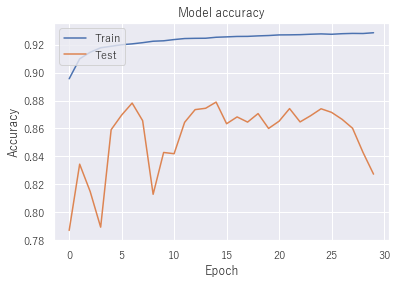

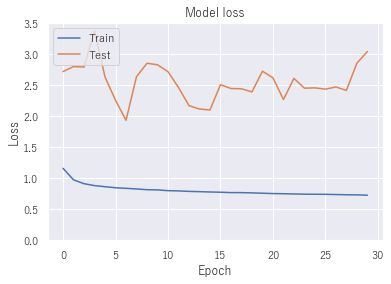

In [156]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim((0, 3.5))
plt.show()

In [157]:
def plot_confusion_matrix(test_y,pred_y,class_names,normalize=False):
    cm = confusion_matrix(test_y,pred_y)
    # classes = class_names[unique_labels(test_y,pred_y)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="red", fontsize=16)
    fig.tight_layout()
    return ax

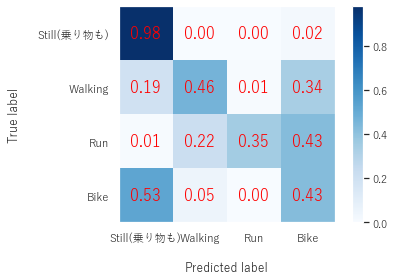

In [158]:
class_names = ['Still(乗り物も)', 'Walking', 'Run', 'Bike']
predict = model.predict_classes(X_test)
plot_confusion_matrix(Y_test, predict, class_names, True)
plt.grid(False)

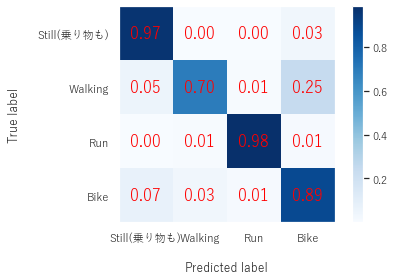

In [159]:
class_names = ['Still(乗り物も)', 'Walking', 'Run', 'Bike']
predict = model.predict_classes(X_train)
plot_confusion_matrix(Y_train, predict, class_names, True)
plt.grid(False)

In [120]:
sample_count = []
for i in range(4):
    sample_count.append(np.sum(Y_train == i))
sample_count

[557016, 97608, 33699, 93640]

In [148]:
np.round(Y_train.shape[0] / np.array(sample_count) * 0.71, 2)

array([ 1.  ,  5.69, 16.48,  5.93])

In [145]:
1/1.4

0.7142857142857143

# Under Samplingで学習する

In [166]:
(Y_train==0)[:, 0]

array([False, False, False, ...,  True,  True,  True])

In [167]:
train_Still = X_train[(Y_train==0)[:, 0]]
train_Walking = X_train[(Y_train==1)[:, 0]]
train_Run = X_train[(Y_train==2)[:, 0]]
train_Bike = X_train[(Y_train==3)[:, 0]]

train_Still.shape, train_Walking.shape, train_Run.shape, train_Bike.shape

((557016, 33, 1), (97608, 33, 1), (33699, 33, 1), (93640, 33, 1))

## Run以外のラベルのサンプル数をRunに合わせる

In [170]:
train_Still = train_Still[np.random.choice(train_Still.shape[0], 33699, replace=False)]
train_Walking = train_Walking[np.random.choice(train_Walking.shape[0], 33699, replace=False)]
train_Bike = train_Bike[np.random.choice(train_Bike.shape[0], 33699, replace=False)]

train_Still.shape, train_Walking.shape, train_Bike.shape

((33699, 33, 1), (33699, 33, 1), (33699, 33, 1))

In [172]:
X_train = np.concatenate([train_Still, train_Walking, train_Run, train_Bike], axis=0)
Y_train = [0] * 33699 + [1] * 33699 + [2] * 33699 + [3] * 33699
Y_train = np.array(Y_train).reshape([-1, 1])
X_train.shape, Y_train.shape

((134796, 33, 1), (134796, 1))

In [173]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, 3, padding='valid', activation='relu', input_shape=(X_train.shape[1], 1), kernel_initializer=he_normal()))
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(2, padding='same'))
model.add(layers.Conv1D(32, 3, padding='same', activation='relu'))
model.add(layers.Conv1D(32, 3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', f1])


In [174]:
history = model.fit(X_train, Y_train, epochs=30, batch_size=512, validation_data=(X_test, Y_test))


Train on 134796 samples, validate on 114740 samples
Epoch 1/30
134796/134796 [==============================] - 3s 20us/sample - loss: 0.4829 - accuracy: 0.8107 - f1: 1.1365 - val_loss: 0.5358 - val_accuracy: 0.7825 - val_f1: 0.4317
Epoch 2/30
134796/134796 [==============================] - 2s 13us/sample - loss: 0.3894 - accuracy: 0.8517 - f1: 1.0315 - val_loss: 0.5624 - val_accuracy: 0.7766 - val_f1: 0.4201
Epoch 3/30
134796/134796 [==============================] - 2s 13us/sample - loss: 0.3659 - accuracy: 0.8617 - f1: 1.0190 - val_loss: 0.5169 - val_accuracy: 0.7920 - val_f1: 0.4131
Epoch 4/30
134796/134796 [==============================] - 2s 13us/sample - loss: 0.3485 - accuracy: 0.8697 - f1: 1.0060 - val_loss: 0.4650 - val_accuracy: 0.8214 - val_f1: 0.4049: 0.3484 - accuracy: 0.8695 - f1: 1.0
Epoch 5/30
134796/134796 [==============================] - 2s 13us/sample - loss: 0.3335 - accuracy: 0.8768 - f1: 0.9960 - val_loss: 0.4161 - val_accuracy: 0.8643 - val_f1: 0.4429
Epoch 

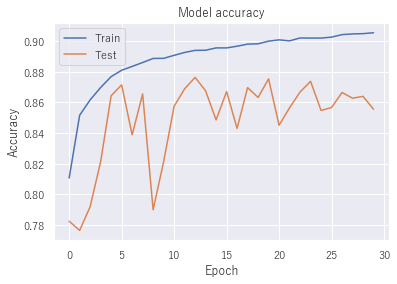

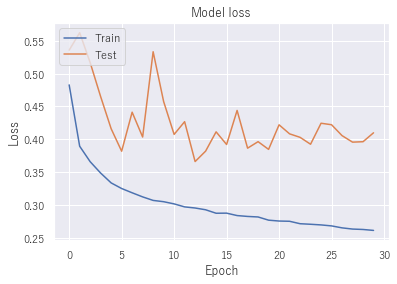

In [180]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.ylim((0, 3.5))
plt.show()

0.8555778281331706

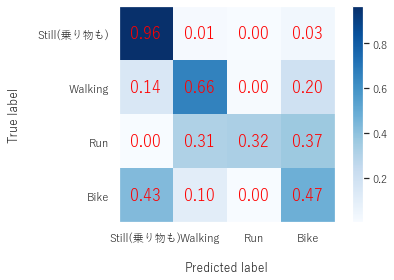

In [179]:
class_names = ['Still(乗り物も)', 'Walking', 'Run', 'Bike']
predict = model.predict_classes(X_test)
plot_confusion_matrix(Y_test, predict, class_names, True)
plt.grid(False)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, predict)

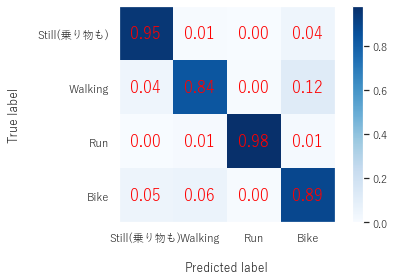

In [177]:
class_names = ['Still(乗り物も)', 'Walking', 'Run', 'Bike']
predict = model.predict_classes(X_train)
plot_confusion_matrix(Y_train, predict, class_names, True)
plt.grid(False)